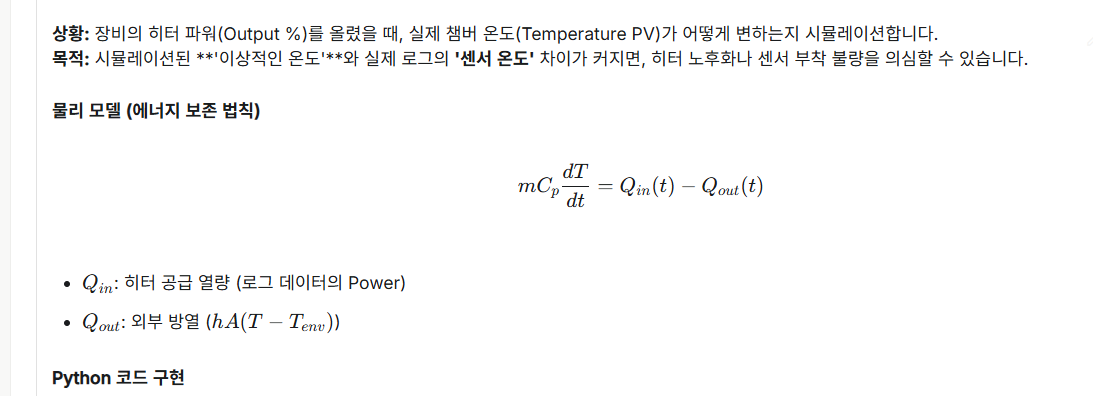

In [ ]:
m, Cp는 고정값, hA(방열계수)는 scipy.optimize.curve_fit을 이용해 정상 장비 데이터에 맞춰두면 됩니다. 이후 hA 값이 변하면 장비 상태 변화를 의미합니다.

In [ ]:
매일 ha 계산
hA  감소 -> 열이 잘 안 빠져나감  -> 챔버 벽면에 Polymer(부산물)가 두껍게 증착되어 단열 효과가 생김 (PM 주기 도래 알림).

hA 증가: 열이 너무 빨리 식음  ->  냉각수 유량이 과다하거나, 단열재 손상 의심.

hA ->  급변: 센서 접촉 불량 혹은 Heater 설치 불량. 혹은 off set 변

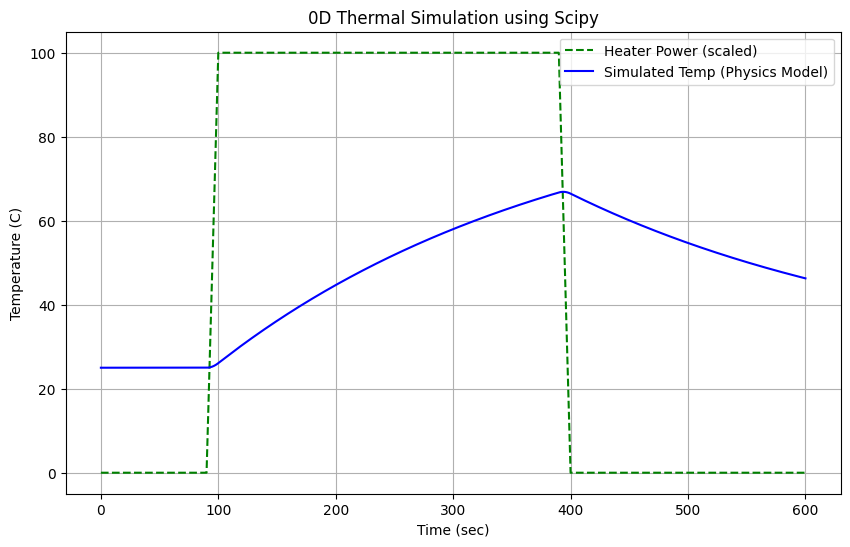

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from scipy.interpolate import interp1d

# 1. 가상의 장비 로그 데이터 생성 (실제 업무에선 csv 로드)
# Time(sec), Heater_Power(W), Actual_Temp(C)
t_log = np.linspace(0, 600, 61)  # 10분간 10초 단위 로그
power_log = np.zeros_like(t_log)
power_log[10:40] = 1000  # 100초~400초 사이에 1000W 인가

# 2. 이산적인 로그 데이터를 연속 함수로 변환 (중요!)
# ODE Solver는 임의의 시간 t에서의 입력값이 필요하므로 보간(Interpolation)함수 생성
power_func = interp1d(t_log, power_log, kind='linear', fill_value="extrapolate")

# 3. 미분방정식 정의 (물리 모델)
def heat_model(T, t, m, Cp, hA, T_env):
    """
    dT/dt = (Input_Power - Heat_Loss) / (Mass * Specific_Heat)
    """
    Q_in = power_func(t)          # 로그 데이터에서 해당 시간의 파워 가져오기
    Q_out = hA * (T - T_env)      # 뉴턴의 냉각 법칙
    dTdt = (Q_in - Q_out) / (m * Cp)
    return dTdt

# 4. 파라미터 설정 (장비 스펙이나 실험을 통해 튜닝 필요)
m = 5.0       # 히터 블록 질량 (kg)
Cp = 900.0    # 알루미늄 비열 (J/kg.K)
hA = 15.0     # 열전달 계수 x 면적 (W/K) - 방열 특성
T_env = 25.0  # 대기 온도
T0 = 25.0     # 초기 온도

# 5. ODE 풀기 (시뮬레이션 수행)
t_sim = np.linspace(0, 600, 6000) # 더 촘촘한 시간 간격으로 계산
T_sim = odeint(heat_model, T0, t_sim, args=(m, Cp, hA, T_env))

# 6. 결과 시각화
plt.figure(figsize=(10, 6))
plt.plot(t_log, power_log/10, 'g--', label='Heater Power (scaled)')
plt.plot(t_sim, T_sim, 'b-', label='Simulated Temp (Physics Model)')
# 실제 로그 데이터가 있다면 여기에 plt.plot(t_log, real_temp_log)를 추가하여 비교
plt.xlabel('Time (sec)')
plt.ylabel('Temperature (C)')
plt.title('0D Thermal Simulation using Scipy')
plt.legend()
plt.grid(True)
plt.show()

----------------------------------------
정답 hA (Hidden): 2.5
계산된 hA (Fitted): 1.5572
----------------------------------------


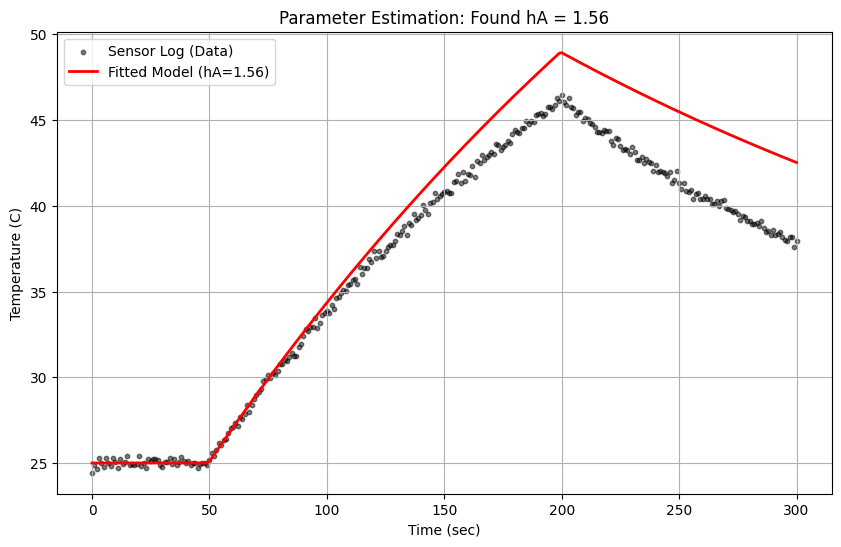

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from scipy.optimize import curve_fit
from scipy.interpolate import interp1d

# ==========================================
# 1. 상황 설정: 실제 장비 로그 데이터 (가정)
# ==========================================
# 실제 업무에선 pd.read_csv() 등으로 불러오세요.
t_log = np.linspace(0, 300, 301)  # 0~300초 (1초 간격)

# 히터 파워: 50초~200초 동안 100W 인가
power_log = np.zeros_like(t_log)
power_log[50:200] = 100.0 

# 파워 데이터를 연속 함수로 변환 (ODE Solver용)
power_func = interp1d(t_log, power_log, kind='linear', fill_value="extrapolate", bounds_error=False)

# (가상의) 실제 온도 센서 데이터 생성
# 참값 hA=2.5 라고 가정하고, 노이즈를 섞어 실제 데이터처럼 만듭니다.
def true_process(y, t):
    m, Cp = 1.0, 500.0
    true_hA = 2.5  # <--- 우리가 찾아내야 할 정답
    Q_in = power_func(t)
    dTdt = (Q_in - true_hA * (y - 25.0)) / (m * Cp)
    return dTdt

temp_real_data = odeint(true_process, 25.0, t_log).flatten()
# 센서 노이즈 추가 (현실감 부여)
temp_real_data += np.random.normal(0, 0.2, size=len(t_log))

# ==========================================
# 2. 물리 모델 정의 (미분방정식)
# ==========================================
def heat_ode(T, t, hA, m, Cp, T_env):
    """
    T: 현재 온도
    t: 현재 시간
    hA: 우리가 찾고 싶은 미지수 (열전달 계수)
    m, Cp, T_env: 이미 알고 있는 상수들
    """
    Q_in = power_func(t) # 위에서 만든 보간 함수 사용
    dTdt = (Q_in - hA * (T - T_env)) / (m * Cp)
    return dTdt

# ==========================================
# 3. curve_fit용 래퍼(Wrapper) 함수 만들기 (핵심!)
# ==========================================
# curve_fit은 func(x, parameter) 형태만 받을 수 있습니다.
# 따라서 내부에서 odeint를 돌리고 결과값(온도 배열)을 리턴하는 함수를 만들어야 합니다.

def model_function(t, hA_guess):
    # 알고 있는 고정 상수들
    m_fixed = 1.0     # kg
    Cp_fixed = 500.0  # J/kgK
    T_env_fixed = 25.0
    T0 = 25.0         # 초기 온도는 로그의 첫 번째 값 사용 (temp_real_data[0])
    
    # ODE 풀기 (hA_guess는 curve_fit이 계속 바꿔가며 넣어봅니다)
    sol = odeint(heat_ode, T0, t, args=(hA_guess, m_fixed, Cp_fixed, T_env_fixed))
    
    # curve_fit은 1차원 배열을 원하므로 flatten() 해줍니다.
    return sol.flatten()

# ==========================================
# 4. 최적화 실행 (hA 찾기)
# ==========================================
# 초기 추정값(p0)을 대략 넣어주면 더 잘 찾습니다.
p0 = [1.5] # hA가 대충 1.0 쯤 되지 않을까? 하고 던져줌

# popt: 최적화된 파라미터 리스트, pcov: 공분산(오차 추정용)
popt, pcov = curve_fit(model_function, t_log, temp_real_data, p0=p0)

estimated_hA = popt[0]

print(f"----------------------------------------")
print(f"정답 hA (Hidden): 2.5")
print(f"계산된 hA (Fitted): {estimated_hA:.4f}")
print(f"----------------------------------------")

# ==========================================
# 5. 결과 시각화
# ==========================================
plt.figure(figsize=(10, 6))
plt.scatter(t_log, temp_real_data, s=10, c='black', alpha=0.5, label='Sensor Log (Data)')
plt.plot(t_log, model_function(t_log, estimated_hA), 'r-', linewidth=2, label=f'Fitted Model (hA={estimated_hA:.2f})')
plt.title(f'Parameter Estimation: Found hA = {estimated_hA:.2f}')
plt.xlabel('Time (sec)')
plt.ylabel('Temperature (C)')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
1. 여러 초깃값 돌려보기

In [4]:
import numpy as np
from scipy.optimize import curve_fit
from scipy.integrate import odeint
# (이전의 model_function, t_log, temp_real_data 등의 변수는 그대로 있다고 가정)

# 1. 시도해볼 초기값 리스트 생성 (Log scale로 넓게 잡는 것이 요령)
# 예: 0.1, 1.0, 10.0, 100.0
guess_list = [0.1, 1.0, 5.0, 10.0, 50.0]

best_hA = None
min_error = np.inf  # 무한대로 초기화

print(f"{'Initial Guess':<15} | {'Fitted hA':<15} | {'Error (MSE)':<15}")
print("-" * 50)

for guess in guess_list:
    try:
        # 2. 각 초기값으로 curve_fit 실행
        popt, _ = curve_fit(model_function, t_log, temp_real_data, p0=[guess])
        current_hA = popt[0]
        
        # 3. 에러(MSE) 계산: (실측값 - 예측값)^2 의 평균
        predicted_temp = model_function(t_log, current_hA)
        mse = np.mean((temp_real_data - predicted_temp)**2)
        
        print(f"{guess:<15.1f} | {current_hA:<15.4f} | {mse:<15.4f}")
        
        # 4. 가장 에러가 작은 값 저장
        if mse < min_error:
            min_error = mse
            best_hA = current_hA
            
    except RuntimeError:
        # 수렴하지 못하는 경우(발산) 패스
        print(f"{guess:<15.1f} | {'Failed':<15} | {'-':<15}")

print("-" * 50)
print(f"🏆 최종 선택된 hA: {best_hA:.4f} (Error: {min_error:.4f})")

Initial Guess   | Fitted hA       | Error (MSE)    
--------------------------------------------------
0.1             | 0.1000          | 63.4510        
1.0             | 1.1201          | 15.5107        
5.0             | 2.5003          | 0.0427         
10.0            | 6.3476          | 35.1607        
50.0            | 8.7083          | 60.1624        
--------------------------------------------------
🏆 최종 선택된 hA: 2.5003 (Error: 0.0427)


In [ ]:
2. 범위 정해주기

In [5]:
from scipy.optimize import differential_evolution

# 1. 목적 함수(Loss Function) 정의
# : 입력값(hA)을 받아, 에러(MSE)를 리턴하는 함수
def objective_function(params):
    hA_val = params[0]
    
    # 물리적 불가능 영역(음수) 방지
    if hA_val <= 0:
        return 1e9 
        
    # 모델 예측
    predicted_temp = model_function(t_log, hA_val)
    
    # 에러 계산 (Mean Squared Error)
    mse = np.mean((temp_real_data - predicted_temp)**2)
    return mse

# 2. 탐색 범위 설정 (Bounds)
# hA가 0.1에서 100 사이 어딘가에 있을 것이라고 범위만 지정
bounds = [(0.1, 100.0)]

# 3. 전역 최적화 수행
result = differential_evolution(
    objective_function, 
    bounds, 
    strategy='best1bin', 
    maxiter=50,    # 반복 횟수 (정밀도와 속도 타협)
    popsize=15,    # 모집단 크기
    tol=0.01       # 허용 오차
)

best_hA_global = result.x[0]

print(f"----------------------------------------")
print(f"Differential Evolution 결과")
print(f"최적 hA: {best_hA_global:.4f}")
print(f"최소 에러: {result.fun:.4f}")
print(f"계산 횟수: {result.nfev} 번") # 함수 호출 횟수
print(f"----------------------------------------")

----------------------------------------
Differential Evolution 결과
최적 hA: 2.5004
최소 에러: 0.0427
계산 횟수: 221 번
----------------------------------------
